In [0]:
# Source : https://github.com/tdeboissiere/DeepLearningImplementations/tree/master/GAN 
# Project Title : Convert GAN implementation into IPython Notebook

# Current Progress
# 1. Convert main model,training files
# 2. Create HDF5 dataset to be used for training
# 3. Trained network on CelebA dataset for 400 epochs
# 4. Improve implementation to generate better quality images using other GAN implementations like BEGAN, PGGAN etc. (WIP)
# 5. Add descriptions in code (WIP)

In [0]:
!git clone https://github.com/siddharthalodha/DCGAN_KERAS.git
!cp -r DCGAN_KERAS/models .
!cp -r DCGAN_KERAS/figures .
!cp -r DCGAN_KERAS/utils .  

# Download CelebA dataset from Google drive

In [0]:
#Code to download CelebA hdf5 dataset from google drive
!pip install PyDrive

from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileId = drive.CreateFile({'id': '1cUBPxqU-9Y6f_OAfPwdRmPg7ruZ2sfdk'})
print(fileId['title'])  # CelebA Dataset
fileId.GetContentFile('CelebA_64_data.h5')  # Save Drive file as a local file

# Import libraries

In [16]:
!pip install -q keras
import keras

#Fixing graphviz pydot installation for plot_model function to work
#!sudo apt-get install graphviz
#!pip install pydot
#!pip install graphviz
#!pip install graphviz pydot

!apt-get -qq install -y graphviz && pip install -q pydot

import graphviz
import pydot
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [0]:
import os
import sys
import time

import keras.backend as K

import tensorflow as tf

from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout, Activation, Lambda, Reshape
from keras.layers.convolutional import Conv2D, Deconv2D, ZeroPadding2D, UpSampling2D
from keras.layers import Input, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization

from keras.utils import generic_utils
from keras.optimizers import Adam, SGD
from keras.utils import plot_model
from keras.utils.generic_utils import Progbar

from IPython.core.debugger import set_trace

sys.path.append("./utils") # Utils
import general_utils
import data_utils #Being used for importing data,generating batches (CelebA Data is currently stored in an hdf5 file)
%matplotlib inline

#!mkdir /figures

** Check the Version of TensorFlow and Access to GPU **

In [18]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

Found GPU at: /device:GPU:0


# Define Hyperparameters

In [0]:
#Hyperparameters

backend="tensorflow" #Specify backend to be used
dset="celebA" #Specify dataset to be used, currently supported : mnist/celebA
generator="upsampling" #Generator to be used : upsampling/deconv
model_name="CNN" #Name of model
batch_size=32 #Batch size to be used 
n_batch_per_epoch=200 #Number of batches per epoch
nb_epoch=400 #Number of epochs
epoch=10 #Epoch size => Used for progress bars 
nb_classes=2 #Number of classes
do_plot=True #Plotting during execution
bn_mode=2 #Batch normalization
img_dim=64 #Dimension of image
label_smoothing="store_true" #Label smoothing
label_flipping=0 #Label flipping
noise_scale=0.5 
use_mbd="store_true"
image_data_format = "channels_last"

#  Define generator function#1 : Upsampling

Preferable for CelebA dataset

In [0]:
def generator_upsampling(noise_dim, img_dim, bn_mode, model_name="generator_upsampling", dset="celebA"):
    """
    Generator model of the DCGAN
    args : img_dim (tuple of int) num_chan, height, width
           pretr_weights_file (str) file holding pre trained weights
    returns : model (keras NN) the Neural Net model
    """

    s = img_dim[1]
    f = 512

    if dset == "mnist":
        start_dim = int(s / 4)
        nb_upconv = 2
    else:
        start_dim = int(s / 16)
        nb_upconv = 4

    if K.image_data_format() == "channels_first":
        bn_axis = 1
        reshape_shape = (f, start_dim, start_dim)
        output_channels = img_dim[0]
    else:
        reshape_shape = (start_dim, start_dim, f)
        bn_axis = -1
        output_channels = img_dim[-1]

    gen_input = Input(shape=noise_dim, name="generator_input")

    x = Dense(f * start_dim * start_dim, input_dim=noise_dim)(gen_input)
    x = Reshape(reshape_shape)(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)

    # Upscaling blocks
    for i in range(nb_upconv):
        x = UpSampling2D(size=(2, 2))(x)
        nb_filters = int(f / (2 ** (i + 1)))
        x = Conv2D(nb_filters, (3, 3), padding="same")(x)
        x = BatchNormalization(axis=1)(x)
        x = Activation("relu")(x)
        x = Conv2D(nb_filters, (3, 3), padding="same")(x)
        x = Activation("relu")(x)

    x = Conv2D(output_channels, (3, 3), name="gen_Conv2D_final", padding="same", activation='tanh')(x)

    generator_model = Model(inputs=[gen_input], outputs=[x], name=model_name)

    return generator_model

# Define generator function#2 : Deconvolution

Preferable for MNIST dataset

In [0]:
def generator_deconv(noise_dim, img_dim, bn_mode, batch_size, model_name="generator_deconv", dset="mnist"):
    """
    Generator model of the DCGAN
    args : nb_classes (int) number of classes
           img_dim (tuple of int) num_chan, height, width
           pretr_weights_file (str) file holding pre trained weights
    returns : model (keras NN) the Neural Net model
    """

    assert K.backend() == "tensorflow", "Deconv not implemented with theano"

    s = img_dim[1]
    f = 512

    if dset == "mnist":
        start_dim = int(s / 4)
        nb_upconv = 2
    else:
        start_dim = int(s / 16)
        nb_upconv = 4

    reshape_shape = (start_dim, start_dim, f)
    bn_axis = -1
    output_channels = img_dim[-1]

    gen_input = Input(shape=noise_dim, name="generator_input")

    x = Dense(f * start_dim * start_dim, input_dim=noise_dim)(gen_input)
    x = Reshape(reshape_shape)(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)

    # Transposed conv blocks
    for i in range(nb_upconv - 1):
        nb_filters = int(f / (2 ** (i + 1)))
        s = start_dim * (2 ** (i + 1))
        o_shape = (batch_size, s, s, nb_filters)
        x = Deconv2D(nb_filters, (3, 3), output_shape=o_shape, strides=(2, 2), padding="same")(x)
        x = BatchNormalization(axis=-1)(x)
        x = Activation("relu")(x)

    # Last block
    s = start_dim * (2 ** (nb_upconv))
    o_shape = (batch_size, s, s, output_channels)
    x = Deconv2D(output_channels, (3, 3), output_shape=o_shape, strides=(2, 2), padding="same")(x)
    x = Activation("tanh")(x)

    generator_model = Model(inputs=[gen_input], outputs=[x], name=model_name)

    return generator_model

# Define discriminator function

Implement discriminator to create a discriminator neural network that discriminates on images. 


In [0]:
def DCGAN(generator, discriminator_model, noise_dim, img_dim):

    noise_input = Input(shape=noise_dim, name="noise_input")

    generated_image = generator(noise_input)
    DCGAN_output = discriminator_model(generated_image)

    DCGAN = Model(inputs=[noise_input],
                  outputs=[DCGAN_output],
                  name="DCGAN")
    return DCGAN

In [0]:
def DCGAN_discriminator(noise_dim, img_dim, bn_mode, model_name="DCGAN_discriminator", dset="celebA", use_mbd=False):
    """
    Discriminator model of the DCGAN
    args : img_dim (tuple of int) num_chan, height, width
           pretr_weights_file (str) file holding pre trained weights
    returns : model (keras NN) the Neural Net model
    """

    if K.image_data_format() == "channels_first":
        bn_axis = 1
    else:
        bn_axis = -1

    disc_input = Input(shape=img_dim, name="discriminator_input")

    if dset == "mnist":
        list_f = [128]

    else:
        list_f = [64, 128, 256]

    # First conv
    x = Conv2D(32, (3, 3), strides=(2, 2), name="disc_Conv2D_1", padding="same")(disc_input)
    x = BatchNormalization(axis=bn_axis)(x)
    x = LeakyReLU(0.2)(x)

    # Next convs
    for i, f in enumerate(list_f):
        name = "disc_Conv2D_%s" % (i + 2)
        x = Conv2D(f, (3, 3), strides=(2, 2), name=name, padding="same")(x)
        x = BatchNormalization(axis=bn_axis)(x)
        x = LeakyReLU(0.2)(x)

    x = Flatten()(x)

    def minb_disc(x):
        diffs = K.expand_dims(x, 3) - K.expand_dims(K.permute_dimensions(x, [1, 2, 0]), 0)
        abs_diffs = K.sum(K.abs(diffs), 2)
        x = K.sum(K.exp(-abs_diffs), 2)

        return x

    def lambda_output(input_shape):
        return input_shape[:2]

    num_kernels = 100
    dim_per_kernel = 5

    M = Dense(num_kernels * dim_per_kernel, use_bias=False, activation=None)
    MBD = Lambda(minb_disc, output_shape=lambda_output)

    if use_mbd:
        x_mbd = M(x)
        x_mbd = Reshape((num_kernels, dim_per_kernel))(x_mbd)
        x_mbd = MBD(x_mbd)
        x = Concatenate(axis=bn_axis)([x, x_mbd])

    x = Dense(2, activation='softmax', name="disc_dense_2")(x)

    discriminator_model = Model(inputs=[disc_input], outputs=[x], name=model_name)

    return discriminator_model

# Define model loader

Implement loader to load specific models : 
1. Generators : Upsampling, Deconvolution
2. Discriminator : DCGAN


In [0]:
def load(model_name, noise_dim, img_dim, bn_mode, batch_size, dset="mnist", use_mbd=False):

    if model_name == "generator_upsampling":
        model = generator_upsampling(noise_dim, img_dim, bn_mode, model_name=model_name, dset=dset)
        model.summary()
        plot_model(model, to_file='./figures/%s.png' % model_name, show_shapes=True, show_layer_names=True)
        return model
    if model_name == "generator_deconv":
        model = generator_deconv(noise_dim, img_dim, bn_mode, batch_size, model_name=model_name, dset=dset)
        model.summary()
        plot_model(model, to_file='./figures/%s.png' % model_name, show_shapes=True, show_layer_names=True)
        return model
    if model_name == "DCGAN_discriminator":
        model = DCGAN_discriminator(noise_dim, img_dim, bn_mode, model_name=model_name, dset=dset, use_mbd=use_mbd)
        model.summary()
        plot_model(model, to_file='./figures/%s.png' % model_name, show_shapes=True, show_layer_names=True)
        return model

# Train the network

> **Optimizer used** : 

>> Generator : Adam with LR .0002

>> Discriminator : SGD with momentum and LR 0.001







In [0]:
def train_GAN(batch_size,n_batch_per_epoch,nb_epoch,generator,model_name,image_data_format,img_dim,bn_mode,label_smoothing,label_flipping,noise_scale,dset,use_mbd,epoch_size):
    # Setup environment (logging directory etc)
    general_utils.setup_logging(model_name)

    # Load and rescale data
    if dset == "celebA":
        X_real_train = data_utils.load_celebA(img_dim, image_data_format)
    if dset == "mnist":
        X_real_train, _, _, _ = data_utils.load_mnist(image_data_format)
    img_dim = X_real_train.shape[-3:]
    noise_dim = (100,)
    
    try:

        # Create optimizers
        opt_dcgan = Adam(lr=2E-4, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
        opt_discriminator = SGD(lr=1E-3, momentum=0.9, nesterov=True)

        # Load generator model
        generator_model = load("generator_%s" % generator,
                                      noise_dim,
                                      img_dim,
                                      bn_mode,
                                      batch_size,
                                      dset=dset,
                                      use_mbd=use_mbd)
        
        # Load discriminator model
        discriminator_model = load("DCGAN_discriminator",
                                          noise_dim,
                                          img_dim,
                                          bn_mode,
                                          batch_size,
                                          dset=dset,
                                          use_mbd=use_mbd)

        generator_model.compile(loss='mse', optimizer=opt_discriminator)
        discriminator_model.trainable = False
        DCGAN_model = DCGAN(generator_model,
                                   discriminator_model,
                                   noise_dim,
                                   img_dim)
        
        loss = ['binary_crossentropy']
        loss_weights = [1]
        DCGAN_model.compile(loss=loss, loss_weights=loss_weights, optimizer=opt_dcgan)

        discriminator_model.trainable = True
        discriminator_model.compile(loss='binary_crossentropy', optimizer=opt_discriminator)

        gen_loss = 100
        disc_loss = 100

        # Start training
        print("Start training")
        for e in range(nb_epoch):
            #Initialize progbar and batch counter
            #progbar = Progbar(epoch_size)
            batch_counter = 1
            start = time.time()
            for X_real_batch in data_utils.gen_batch(X_real_train, batch_size):

                # Create a batch to feed the discriminator model
                X_disc, y_disc = data_utils.get_disc_batch(X_real_batch,
                                                           generator_model,
                                                           batch_counter,
                                                           batch_size,
                                                           noise_dim,
                                                           noise_scale=noise_scale,
                                                           label_smoothing=label_smoothing,
                                                           label_flipping=label_flipping)

                # Update the discriminator
                disc_loss = discriminator_model.train_on_batch(X_disc, y_disc)

                # Create a batch to feed the generator model
                X_gen, y_gen = data_utils.get_gen_batch(batch_size, noise_dim, noise_scale=noise_scale)

                # Freeze the discriminator
                discriminator_model.trainable = False
                gen_loss = DCGAN_model.train_on_batch(X_gen, y_gen)
                # Unfreeze the discriminator
                discriminator_model.trainable = True

                batch_counter += 1
                #progbar.add(batch_size, values=[("D logloss", disc_loss),
                #                                ("G logloss", gen_loss)])

                 #Save images for visualization
                if batch_counter % 100 == 0:
                    data_utils.plot_generated_batch(X_real_batch, generator_model,
                                                    batch_size, noise_dim, image_data_format)
                    
                if batch_counter >= n_batch_per_epoch:
                    break

            print("")
            print('Epoch %s/%s, Time: %s, Discriminator loss:%s,Generator loss:%s' % (e + 1, nb_epoch, time.time() - start,disc_loss,gen_loss))

            #Save weights for generator,discriminator and DCGAN
            if e % 5 == 0:
                gen_weights_path = os.path.join('./models/%s/gen_weights_epoch%s.h5' % (model_name, e))
                generator_model.save_weights(gen_weights_path, overwrite=True)

                disc_weights_path = os.path.join('./models/%s/disc_weights_epoch%s.h5' % (model_name, e))
                discriminator_model.save_weights(disc_weights_path, overwrite=True)

                DCGAN_weights_path = os.path.join('./models/%s/DCGAN_weights_epoch%s.h5' % (model_name, e))
                DCGAN_model.save_weights(DCGAN_weights_path, overwrite=True)
    except Exception as e:
            print(e)

In [26]:
os.environ["KERAS_BACKEND"] = "tensorflow" #Set backend to tensorflow
image_data_format = "channels_last" #Setting image data format for tensorflow
K.set_image_data_format(image_data_format)    
# Launch training
train_GAN(batch_size,n_batch_per_epoch,nb_epoch,generator,model_name,image_data_format,img_dim,bn_mode,label_smoothing,label_flipping,noise_scale,dset,use_mbd,epoch)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 256)         1179904   
__________


Epoch 9/400, Time: 25.417667627334595, Discriminator loss:0.8036578,Generator loss:2.7009077

Epoch 10/400, Time: 25.477765321731567, Discriminator loss:0.8665247,Generator loss:2.344607

Epoch 11/400, Time: 25.464698791503906, Discriminator loss:0.86974764,Generator loss:2.3050017

Epoch 12/400, Time: 25.510327577590942, Discriminator loss:0.7687987,Generator loss:2.819724

Epoch 13/400, Time: 25.479650020599365, Discriminator loss:0.7854411,Generator loss:2.933866

Epoch 14/400, Time: 25.541784048080444, Discriminator loss:0.7506685,Generator loss:2.677404

Epoch 15/400, Time: 25.4789822101593, Discriminator loss:0.77409697,Generator loss:3.0198812

Epoch 16/400, Time: 25.521225214004517, Discriminator loss:0.82451767,Generator loss:3.1728673

Epoch 17/400, Time: 25.47446632385254, Discriminator loss:0.7647823,Generator loss:3.4843216

Epoch 18/400, Time: 25.48209500312805, Discriminator loss:0.7956006,Generator loss:3.6024318

Epoch 19/400, Time: 25.427128553390503, Discriminator l


Epoch 54/400, Time: 25.614259481430054, Discriminator loss:0.9584865,Generator loss:3.964797

Epoch 55/400, Time: 25.561535120010376, Discriminator loss:0.7612124,Generator loss:3.3604333

Epoch 56/400, Time: 25.596927404403687, Discriminator loss:0.82662094,Generator loss:3.990996

Epoch 57/400, Time: 25.589436292648315, Discriminator loss:0.77688205,Generator loss:3.3828979

Epoch 58/400, Time: 25.446192741394043, Discriminator loss:0.7663838,Generator loss:3.914715

Epoch 59/400, Time: 25.5228111743927, Discriminator loss:0.7367066,Generator loss:3.8608644

Epoch 60/400, Time: 25.589176654815674, Discriminator loss:0.7339461,Generator loss:4.7999883

Epoch 61/400, Time: 25.55647039413452, Discriminator loss:0.87983465,Generator loss:4.8828187

Epoch 62/400, Time: 25.474472999572754, Discriminator loss:0.75728476,Generator loss:4.5335603

Epoch 63/400, Time: 25.608210563659668, Discriminator loss:0.78013766,Generator loss:3.5449378

Epoch 64/400, Time: 25.562493562698364, Discrimina


Epoch 99/400, Time: 25.563966989517212, Discriminator loss:0.7327819,Generator loss:3.8752995

Epoch 100/400, Time: 25.52562689781189, Discriminator loss:0.7974061,Generator loss:3.7125373

Epoch 101/400, Time: 25.43826961517334, Discriminator loss:0.74038494,Generator loss:3.3761125

Epoch 102/400, Time: 25.443397760391235, Discriminator loss:0.7593807,Generator loss:4.033491

Epoch 103/400, Time: 25.425688982009888, Discriminator loss:0.7804676,Generator loss:3.9688418

Epoch 104/400, Time: 25.468080520629883, Discriminator loss:0.8122084,Generator loss:4.145981

Epoch 105/400, Time: 25.544278144836426, Discriminator loss:0.7662904,Generator loss:3.9583013

Epoch 106/400, Time: 25.563884496688843, Discriminator loss:0.7547025,Generator loss:3.4064903

Epoch 107/400, Time: 25.544668197631836, Discriminator loss:0.7867565,Generator loss:5.3775406

Epoch 108/400, Time: 25.559525728225708, Discriminator loss:0.8236811,Generator loss:3.892352

Epoch 109/400, Time: 25.53370475769043, Disc


Epoch 144/400, Time: 25.48842430114746, Discriminator loss:0.76240313,Generator loss:4.3390226

Epoch 145/400, Time: 25.337879419326782, Discriminator loss:0.7190508,Generator loss:4.3618765

Epoch 146/400, Time: 25.433517932891846, Discriminator loss:0.73857313,Generator loss:4.2145967

Epoch 147/400, Time: 25.35787272453308, Discriminator loss:0.726884,Generator loss:4.437931

Epoch 148/400, Time: 25.382691621780396, Discriminator loss:0.80137855,Generator loss:3.2165775

Epoch 149/400, Time: 25.40341091156006, Discriminator loss:0.73085403,Generator loss:3.931345

Epoch 150/400, Time: 25.48907160758972, Discriminator loss:0.7365993,Generator loss:3.8840406

Epoch 151/400, Time: 25.38463306427002, Discriminator loss:0.732539,Generator loss:5.0562916

Epoch 152/400, Time: 25.42603373527527, Discriminator loss:0.730526,Generator loss:4.6891584

Epoch 153/400, Time: 25.43913507461548, Discriminator loss:0.72221076,Generator loss:3.790245

Epoch 154/400, Time: 25.35477590560913, Discrim


Epoch 189/400, Time: 25.31636071205139, Discriminator loss:0.7494079,Generator loss:5.0579443

Epoch 190/400, Time: 25.32339596748352, Discriminator loss:0.7728934,Generator loss:4.6163273

Epoch 191/400, Time: 25.300275325775146, Discriminator loss:0.8786587,Generator loss:3.5946045

Epoch 192/400, Time: 25.400651216506958, Discriminator loss:0.71936774,Generator loss:4.292113

Epoch 193/400, Time: 25.289916276931763, Discriminator loss:0.74036705,Generator loss:3.8051167

Epoch 194/400, Time: 25.341846704483032, Discriminator loss:0.7300576,Generator loss:4.4073305

Epoch 195/400, Time: 25.294737339019775, Discriminator loss:0.772606,Generator loss:3.9135437

Epoch 196/400, Time: 25.324312448501587, Discriminator loss:1.0046091,Generator loss:3.7819097

Epoch 197/400, Time: 25.37304711341858, Discriminator loss:0.79667103,Generator loss:3.4473047

Epoch 198/400, Time: 25.56858777999878, Discriminator loss:0.85705584,Generator loss:4.0487256

Epoch 199/400, Time: 25.29307460784912, D


Epoch 234/400, Time: 25.16232180595398, Discriminator loss:0.718575,Generator loss:4.09832

Epoch 235/400, Time: 25.249473094940186, Discriminator loss:0.73430085,Generator loss:4.4671874

Epoch 236/400, Time: 25.29196071624756, Discriminator loss:0.7258399,Generator loss:5.4414425

Epoch 237/400, Time: 25.309568881988525, Discriminator loss:0.72319,Generator loss:4.4935946

Epoch 238/400, Time: 25.372934818267822, Discriminator loss:0.76208806,Generator loss:4.8949127

Epoch 239/400, Time: 25.40139627456665, Discriminator loss:0.7370428,Generator loss:3.8155417

Epoch 240/400, Time: 25.323220252990723, Discriminator loss:0.87662345,Generator loss:3.4916108

Epoch 241/400, Time: 25.311301469802856, Discriminator loss:0.74720705,Generator loss:4.269245

Epoch 242/400, Time: 25.408899784088135, Discriminator loss:0.70960134,Generator loss:4.2986774

Epoch 243/400, Time: 25.333491325378418, Discriminator loss:0.7360014,Generator loss:4.2429037

Epoch 244/400, Time: 25.410701990127563, Di


Epoch 279/400, Time: 25.42949366569519, Discriminator loss:0.75192916,Generator loss:4.0660152

Epoch 280/400, Time: 25.434656858444214, Discriminator loss:0.7794099,Generator loss:4.6446238

Epoch 281/400, Time: 25.363328456878662, Discriminator loss:0.7632223,Generator loss:4.1490946

Epoch 282/400, Time: 25.407517671585083, Discriminator loss:0.7380249,Generator loss:4.0019307

Epoch 283/400, Time: 25.268935680389404, Discriminator loss:0.72133684,Generator loss:4.9448543

Epoch 284/400, Time: 25.38968586921692, Discriminator loss:0.7117786,Generator loss:5.1278243

Epoch 285/400, Time: 25.33071732521057, Discriminator loss:0.74104154,Generator loss:5.5613565

Epoch 286/400, Time: 25.320499420166016, Discriminator loss:0.7500451,Generator loss:5.596627

Epoch 287/400, Time: 25.417250871658325, Discriminator loss:0.71371895,Generator loss:4.763358

Epoch 288/400, Time: 25.4078106880188, Discriminator loss:0.7294837,Generator loss:5.152191

Epoch 289/400, Time: 25.417831659317017, Di


Epoch 324/400, Time: 25.411730766296387, Discriminator loss:0.72274977,Generator loss:3.988025

Epoch 325/400, Time: 25.501840829849243, Discriminator loss:0.7335381,Generator loss:4.341914

Epoch 326/400, Time: 25.439570903778076, Discriminator loss:0.71328175,Generator loss:5.858651

Epoch 327/400, Time: 25.47238278388977, Discriminator loss:0.7385373,Generator loss:4.6166

Epoch 328/400, Time: 25.43926978111267, Discriminator loss:0.75322044,Generator loss:4.0496035

Epoch 329/400, Time: 25.467283487319946, Discriminator loss:0.71574616,Generator loss:4.912411

Epoch 330/400, Time: 25.407942295074463, Discriminator loss:0.74336815,Generator loss:4.935869

Epoch 331/400, Time: 25.466627836227417, Discriminator loss:0.72412455,Generator loss:4.9811087

Epoch 332/400, Time: 25.533443689346313, Discriminator loss:0.736416,Generator loss:4.1673546

Epoch 333/400, Time: 25.47719693183899, Discriminator loss:0.73120844,Generator loss:3.7160938

Epoch 334/400, Time: 25.442312002182007, Dis


Epoch 369/400, Time: 25.440097093582153, Discriminator loss:0.72156143,Generator loss:3.6999693

Epoch 370/400, Time: 25.44497776031494, Discriminator loss:0.8467667,Generator loss:4.832093

Epoch 371/400, Time: 25.476295232772827, Discriminator loss:0.74896204,Generator loss:4.017866

Epoch 372/400, Time: 25.46638512611389, Discriminator loss:0.72957206,Generator loss:4.4770994

Epoch 373/400, Time: 25.430037021636963, Discriminator loss:0.75406784,Generator loss:4.1030335

Epoch 374/400, Time: 25.42224097251892, Discriminator loss:0.7216096,Generator loss:4.6503444

Epoch 375/400, Time: 25.440380573272705, Discriminator loss:0.7645092,Generator loss:4.485957

Epoch 376/400, Time: 25.40386986732483, Discriminator loss:0.7425678,Generator loss:5.557222

Epoch 377/400, Time: 25.447174549102783, Discriminator loss:0.73363245,Generator loss:4.7270117

Epoch 378/400, Time: 25.377472400665283, Discriminator loss:0.7228528,Generator loss:5.284007

Epoch 379/400, Time: 25.436359882354736, Di

# Display final generated images

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


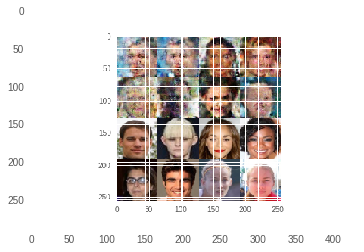

In [27]:
#Display final image
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage, misc


img=mpimg.imread('./figures/current_batch.png')

#image_resized = misc.imresize(img, (1280, 1280))

imgplot = plt.imshow(img)
plt.show()


In [0]:
#import os, signal
#os.kill(os.getpid(), signal.SIGKILL)